# Complete Flow Example
This norebook uses the pipeline to first infer the municipalities that share the same influences over the malaria cases (weekly) and then uses the output to find the metaregions that arise from mobility. 

In [1]:
import sys
sys.path.append('../src/')


In [2]:
# Useful imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from utils.publication_functions import beautify_data_column_name
from sklearn.cluster import KMeans
from flows.specific.custom_flow import CustomFlow

# Data sources
from data_sources.specific.coca import Coca
from data_sources.specific.gold_stock_price import GoldStockPrice
from data_sources.specific.malaria_cases import Malaria
from data_sources.specific.malaria_cases_sivigila_4 import MalariaSivigila4
from data_sources.specific.mock_malaria_cases import MockMalaria
from data_sources.specific.temperature_average import TemperatureAverage
from data_sources.specific.temperature_max import TemperatureMax
from data_sources.specific.temperature_min import TemperatureMin
from data_sources.specific.temperature_average import TemperatureAverage
from data_sources.specific.precipitation_average import PrecipitationAverage
from data_sources.specific.precipitation_total import PrecipitationTotal
from data_sources.specific.deforestation_average import DeforestationAverage
from data_sources.specific.deforestation_total import DeforestationTotal
from data_sources.specific.fb_mobility_recent import FBMobilityRecent

# Embedders
from embedders.specific.identity_embedder import IdentityEmbbeder
from embedders.specific.linear_regression_coefficient_embedder import LinearRegressionCoefficientEmbedder
from embedders.specific.mobility_to_distance_embedder import MobilityToDistanceEmbeder
from embedders.specific.mobility_to_similarity_embedder import MobilityToSimilarityEmbeder

# Clusteres
from clusterers.specific.identity_clusterer import IdentityClusterer
from clusterers.specific.sklearn_vector_clusterer import SklearnVectorClusterer
from clusterers.specific.two_tier_dbscan_clusterer import TwoTierDBSCANClusterer
from clusterers.specific.similarity_community_clusterer import SimilarityCommunityClusterer

# Geographies
from geography.specific.colombian_municipalities import ColombianMunicipalities
from geography.general.geography_from_flow_output import GeographyFromFlowOutput

pd.set_option('display.max_rows', 100)



/home/minigonche/Dropbox/Projects/pathogen_study_regions_generator/env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## 1. Cluster by Mobility

In [3]:
included_sources = []#[GoldStockPrice, Malaria]
included_matrix_sources =  [FBMobilityRecent]
target_mobility_col = "fb_mobility_recent_movement"


flow1 = CustomFlow(ID = 'mobility',
                    name = "Mobility",
                    time_resolution = MONTH,
                    geography= ColombianMunicipalities(),
                    vector_data_sources=included_sources,
                    matrix_data_sources=included_matrix_sources,
                    embedder=[MobilityToSimilarityEmbeder(mobility_col=target_mobility_col)],
                    clusterer=SimilarityCommunityClusterer(similarity_col=target_mobility_col))
                    #embedder=LinearRegressionCoefficientEmbedder(target_col=target_col),
                    #clusterer=SklearnVectorClusterer(ID="kmeans", name="K-Means", sklearn_clusterer= KMeans(n_clusters=5)))

flow1.run()

Starts Flow: Mobility
   Loads Initial Geography
   Loads Data
      Loads Vector Data
      Found 0 elements
      Done
      
      Loads Matrix Data
      Found 1 elements
         Extracts 1 of 1: Facebook Mobility Recent (fb_mobility_recent) 
      Done
      ------------------
   Embedds Data
      Found 1 embedders
         Mobility to Similarity Embeder
   Clusters Data
   Builds Final Geometry
Flow Ended
Done
-----------------


(1122, 5)

<AxesSubplot:>

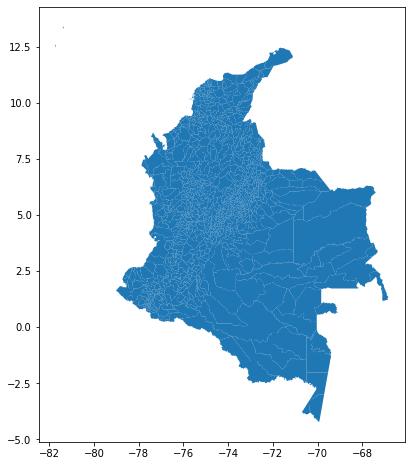

In [4]:
flow1.initial_geometry.plot(figsize = (8,8))

272


<AxesSubplot:>

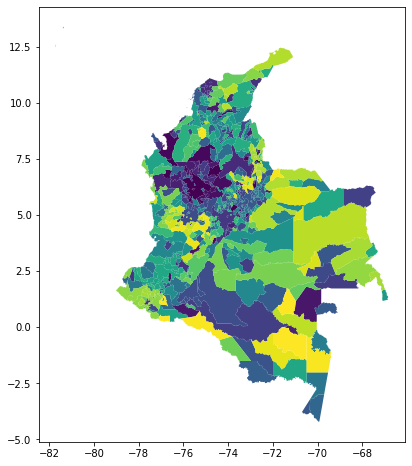

In [5]:
print(flow1.final_geometry.shape[0])
flow1.final_geometry[CLUSTER_ID] = flow1.final_geometry[ID].apply(lambda i : f"cluster {i}")
flow1.final_geometry.plot(figsize = (8,8), column = ID)

In [7]:
flow1.initial_geometry[flow1.initial_geometry.muni_name == 'Guapi']

,ID,dep_name,muni_name,depto_id,geometry
352,19318,Cauca,Guapi,19,"POLYGON ((-77.86824 2.27257, -77.86901 2.27180..."


,dep_name,muni_name
227,Boyaca,Santana
352,Cauca,Guapi


<AxesSubplot:>

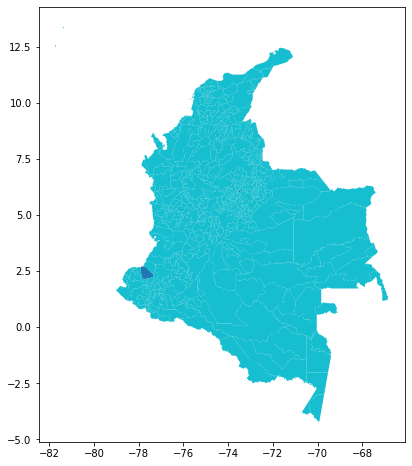

In [8]:
clust_id = flow1.clustered_ids[flow1.clustered_ids.ID == 19318].cluster_id.values[0]

munis = flow1.initial_geometry[flow1.initial_geometry.ID.isin( flow1.clustered_ids[flow1.clustered_ids.cluster_id == clust_id].ID)]
display(munis[['dep_name','muni_name']])

flow1.final_geometry[CLUSTER_ID] = flow1.final_geometry[ID].apply(lambda i : "Bogota" if i == clust_id else "Other")
flow1.final_geometry.plot(figsize = (8,8), column = CLUSTER_ID)

,dep_name,muni_name
79,Bogota,Bogota D.C
300,Boyaca,Mongui
423,Cundinamarca,El Rosal
424,Cundinamarca,Facatativa
426,Cundinamarca,Fosca
427,Cundinamarca,Funza
435,Cundinamarca,Granada
437,Cundinamarca,Guaduas
438,Cundinamarca,Guasca
440,Cundinamarca,Guatavita


<AxesSubplot:>

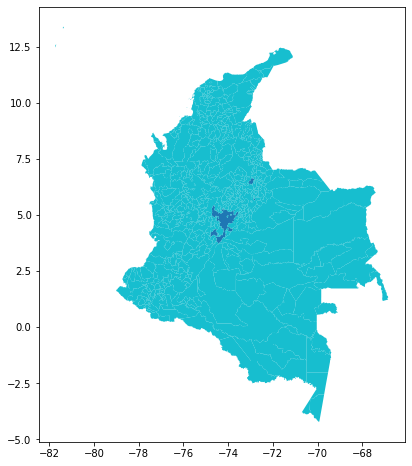

In [7]:
clust_id = flow1.clustered_ids[flow1.clustered_ids.ID == 11001].cluster_id.values[0]

munis = flow1.initial_geometry[flow1.initial_geometry.ID.isin( flow1.clustered_ids[flow1.clustered_ids.cluster_id == clust_id].ID)]
display(munis[['dep_name','muni_name']])

flow1.final_geometry[CLUSTER_ID] = flow1.final_geometry[ID].apply(lambda i : "Bogota" if i == clust_id else "Other")
flow1.final_geometry.plot(figsize = (8,8), column = CLUSTER_ID)

## 2. Cluster Regions by Factors

In [8]:

included_sources = [PrecipitationAverage, Coca, DeforestationAverage, MalariaSivigila4]
included_matrix_sources = []
target_col = 'malaria_sivigila_4_num_cases_sum'
target_mobility_col = "fb_mobility_movement"

flow = CustomFlow(ID = 'basic_malaria',
                    name = "Basic Malaria",
                    time_resolution = MONTH,
                    geography= GeographyFromFlowOutput('municipality_mobility_regions', 'Mobility Regions', flow1),
                    #geography = ColombianMunicipalities(),
                    vector_data_sources=included_sources,
                    matrix_data_sources=included_matrix_sources,
                    embedder=LinearRegressionCoefficientEmbedder(target_col=target_col),
                    clusterer=SklearnVectorClusterer(ID="kmeans", name="K-Means", sklearn_clusterer= KMeans(n_clusters=5)))

flow.run()

Starts Flow: Basic Malaria
   Loads Initial Geography
   Loads Data
      Loads Vector Data
      Found 4 elements
         Extracts 1 of 4: Precipitation Average (precipitation_average) 
         Extracts 2 of 4: Coca (coca) 
         Extracts 3 of 4: Deforestation Average (deforestation_average) 
         Extracts 4 of 4: Malaria (malaria_sivigila_4) 
         Loads Data
         Builds Overlay
         By Dates. From 2006 to 2021
            2006-01-08T00:00:00.000000000
            2006-01-15T00:00:00.000000000
            2006-01-22T00:00:00.000000000
            2006-01-29T00:00:00.000000000
            2006-02-05T00:00:00.000000000
            2006-03-05T00:00:00.000000000
            2006-03-12T00:00:00.000000000
            2006-04-16T00:00:00.000000000
            2006-04-23T00:00:00.000000000
            2006-04-30T00:00:00.000000000
            2006-05-07T00:00:00.000000000
            2006-05-14T00:00:00.000000000
            2006-05-28T00:00:00.000000000
            2006-

## Visualize

In [9]:
munis = flow1.clustered_ids[flow1.clustered_ids.cluster_id.isin(flow.clustered_ids[flow.clustered_ids.cluster_id == 0].ID.values)]
flow1.initial_geometry[flow1.initial_geometry.ID.isin(munis.ID)].dep_name.value_counts()

Antioquia             16
Boyaca                16
Tolima                11
Bolivar                9
Santander              8
Magdalena              6
Cordoba                5
Meta                   5
Amazonas               4
Cundinamarca           4
Choco                  4
Caldas                 3
Caqueta                3
Vaupes                 3
Norte De Santander     3
Nariño                 2
Atlantico              2
Risaralda              1
Huila                  1
Casanare               1
Sucre                  1
Cesar                  1
Guainia                1
Guaviare               1
Valle Del Cauca        1
Cauca                  1
Vichada                1
Name: dep_name, dtype: int64

In [10]:
flow.final_geometry.shape

(5, 2)

<AxesSubplot:>

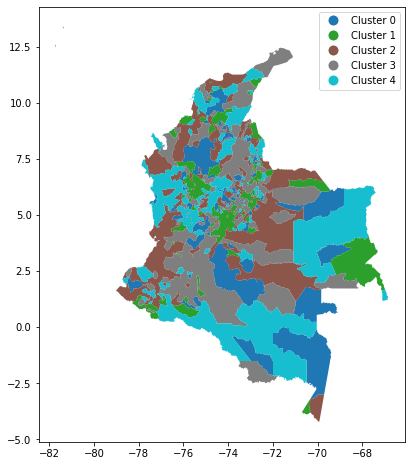

In [11]:
flow.final_geometry[CLUSTER_ID] = flow.final_geometry[ID].apply(lambda i : f"Cluster {i}")
flow.final_geometry.plot(column = CLUSTER_ID, figsize = (8,8), legend = True)

In [12]:
pd.DataFrame(np.round(flow.clusterer.sklearn_clusterer.cluster_centers_,2), columns =  [ beautify_data_column_name(col) for col in flow.df_embedded_vector.columns[1:]])

,Coca,Average Deforestation,Average Precipitation
0,-0.36,0.03,0.03
1,-0.06,0.37,0.02
2,0.38,-0.00,0.00
3,-0.01,0.09,0.02
4,-0.02,-0.17,-0.04


### Map By Factor 

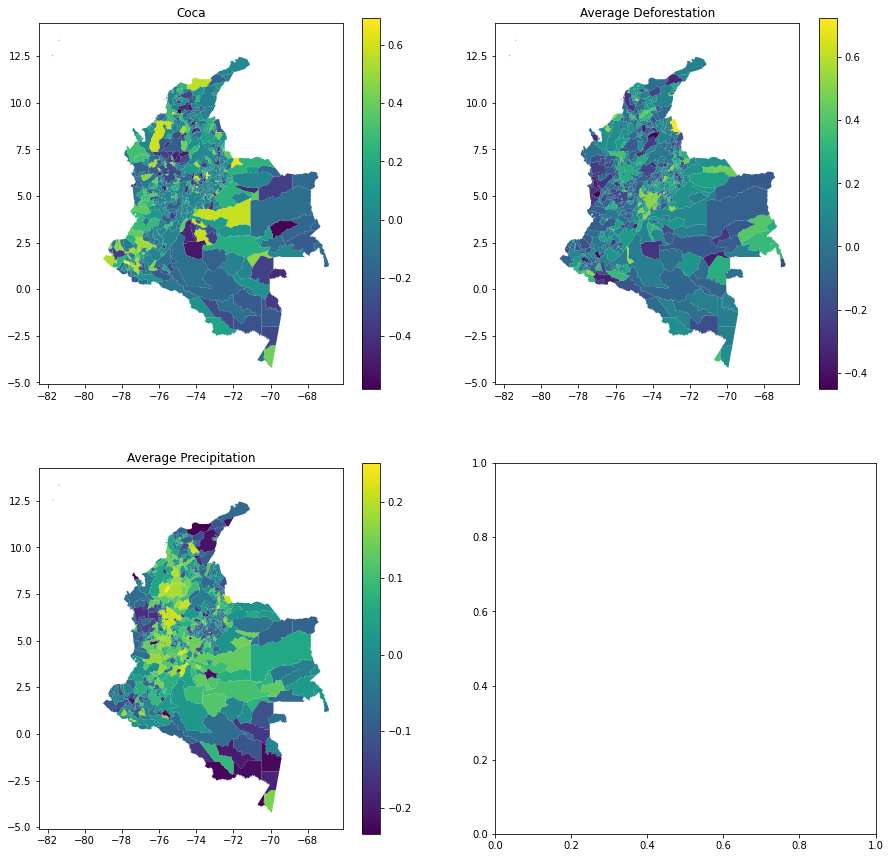

In [14]:
cols = int(np.floor(np.sqrt(flow.df_embedded_vector.shape[1] - 1)))
rows = int(np.ceil((flow.df_embedded_vector.shape[1] - 1)/cols))

cols = 2
rows = 2

fig, axs = plt.subplots(ncols=cols,nrows=rows, figsize=(15,15))

i = 0

for col in flow.df_embedded_vector.columns:
    if col != "ID":
        ax = axs[int(np.floor(i / 2)), i % 2]
        temp_geom = flow.initial_geometry.merge(flow.df_embedded_vector[["ID", col]])
        temp_geom.plot(column = col, figsize = (8,8), legend=True, ax=ax)
        ax.set_title(beautify_data_column_name(col))
        i += 1


coca_coca_total
deforestation_average_deforestation_average
precipitation_average_precipitation_average


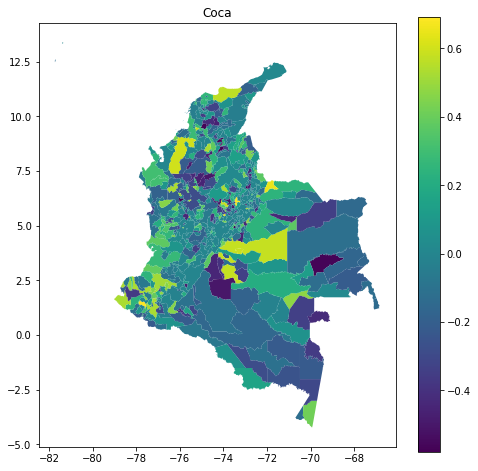

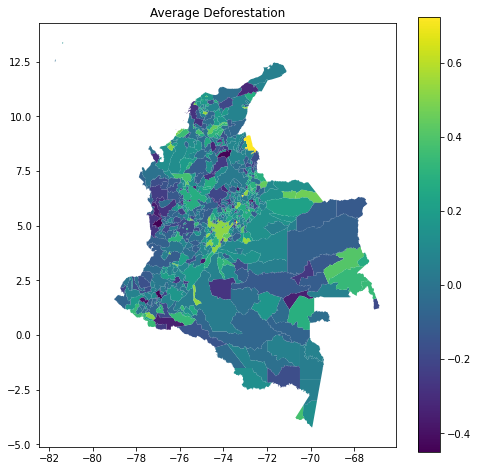

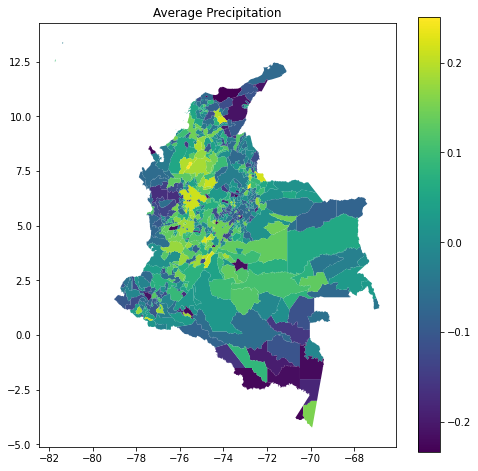

In [15]:
for col in flow.df_embedded_vector.columns:
    if col != "ID":
        temp_geom = flow.initial_geometry.merge(flow.df_embedded_vector[["ID", col]])
        ax = temp_geom.plot(column = col, figsize = (8,8), legend=True)
        ax.set_title(beautify_data_column_name(col))
        print(col)
        #i += 1

In [24]:
df = pd.DataFrame(flow.clusterer.sklearn_clusterer.cluster_centers_)
df.columns = flow.df_embedded_vector.columns[1:]
df.reset_index(inplace = True)
df.rename(columns = {'index' : 'Cluster'}, inplace = True)
display(df)


,Cluster,coca_coca_total,deforestation_average_deforestation_average,malaria_sivigila_4_num_cases_average,precipitation_average_precipitation_average
0,0,0.001153,0.004299,0.933731,0.001399
1,1,0.224801,0.053793,0.354383,0.045117
2,2,0.100090,-0.074440,0.726079,0.010418
3,3,-0.461751,-0.112154,0.304695,0.089110
4,4,-0.174560,0.118099,0.634471,0.017942


<AxesSubplot:>

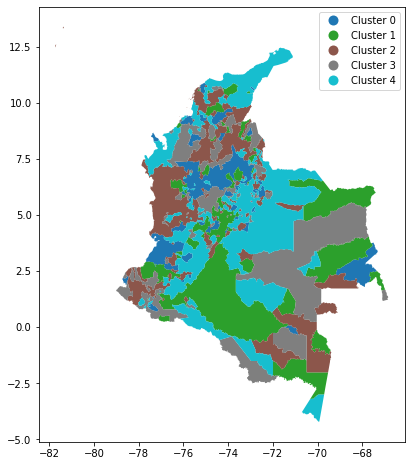

In [ ]:

flow.final_geometry[CLUSTER_ID] = flow.final_geometry[ID].apply(lambda i : f"Cluster {i}")
flow.final_geometry.plot(column = CLUSTER_ID, figsize = (8,8), legend=True)



In [ ]:
import pandas as pd
import geopandas
from shapely import wkt



df = pd.read_csv('temp.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: 'temp.csv'

In [ ]:
df.geometry.area
df['geometry'] = geopandas.GeoSeries.from_wkt(df['geometry'])
df = geopandas.GeoDataFrame(df, geometry='geometry')

In [ ]:
df.groupby(['ID','date']).agg({'temperature_average':'sum'})

temperature_average
ID date                           
0  2000-01-31         7.547021e+12
   2000-02-29         7.556233e+12
   2000-03-31         7.558390e+12
   2000-04-30         7.567763e+12
   2000-05-31         7.570924e+12
...                            ...
4  2019-09-30         1.221955e+12
   2019-10-31         1.215479e+12
   2019-11-30         1.217132e+12
   2019-12-31         1.219647e+12
   2020-01-31         1.218335e+12

[1205 rows x 1 columns]